In [63]:
import os, time
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, dataloader
from torchvision import datasets
import scipy.io as sio
import random
import sklearn
from PIL import Image
from pathlib import Path
from torch import optim
from torchmetrics import Accuracy, Precision, F1Score


In [64]:
main_dir  = Path('C:/Users/benjamin.guerrieri/Documents/AutoSenseBackup/FinalDataset')

In [65]:
from torchvision import transforms
#identifies a transformer to make all images the same size
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (int(120), int(180))),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Grayscale()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(),
    #transforms.Grayscale()

])

In [66]:
main_folder = torchvision.datasets.ImageFolder(main_dir, transform = transformer)
main_folder

Dataset ImageFolder
    Number of datapoints: 19380
    Root location: C:\Users\benjamin.guerrieri\Documents\AutoSenseBackup\FinalDataset
    StandardTransform
Transform: Compose(
               Resize(size=(120, 180), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Grayscale(num_output_channels=1)
           )

In [67]:
classes = main_folder.classes
classes

['Convertible',
 'Coupe',
 'Hatchback',
 'Minivan',
 'SUV',
 'Sedan',
 'Truck',
 'Van']

torch.Size([1, 120, 180])


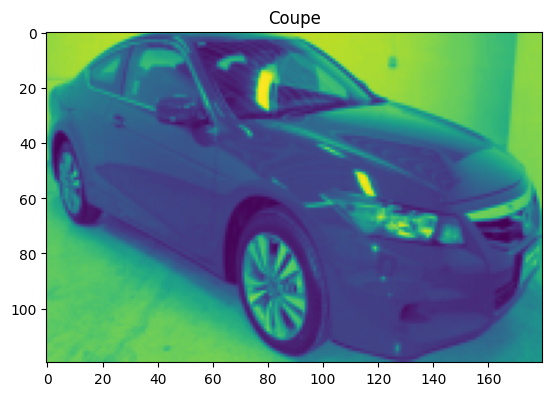

In [68]:
#grabs random image and label in the datafolder
img, label = main_folder[random.randrange(0, len(main_folder))]

import matplotlib.pyplot as plt
img_sample = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img_sample)
plt.title(classes[label]);

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [70]:
import torch.utils.data as data

BATCH_SIZE = 32
NUM_WORKER = 0

# Random split
train_set_size = int(len(main_folder) * .8)   #80% of data for training
valid_set_size = int(len(main_folder) * .1) #10% for validation
test_set_size = int(len(main_folder) - train_set_size - valid_set_size) #10% for testing
train_set, valid_set, test_set = data.random_split(main_folder, [train_set_size, valid_set_size, test_set_size])

train_set_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)  
valid_set_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER) 
test_set_loader  = data.DataLoader(test_set , batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKER)
dataloaders = {'train': train_set_loader, 'val': valid_set_loader, 'test': test_set_loader}

"""
Training Set: this data set is used to adjust the weights on the neural network.

Validation Set: this data set is used to minimize overfitting. You're not adjusting the weights of the network with this data set, you're just 
verifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been 
shown to the network before, or at least the network hasn't trained on it (i.e. validation data set). If the accuracy over the training data set increases, 
but the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.

Testing Set: this data set is used only for testing the final solution in order to confirm the actual predictive power of the network.
"""


"\nTraining Set: this data set is used to adjust the weights on the neural network.\n\nValidation Set: this data set is used to minimize overfitting. You're not adjusting the weights of the network with this data set, you're just \nverifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been \nshown to the network before, or at least the network hasn't trained on it (i.e. validation data set). If the accuracy over the training data set increases, \nbut the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.\n\nTesting Set: this data set is used only for testing the final solution in order to confirm the actual predictive power of the network.\n"

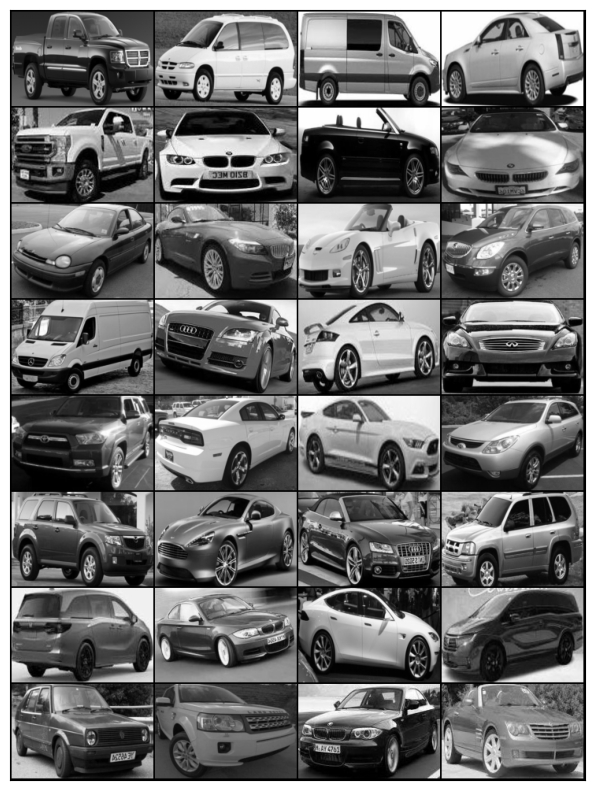

In [71]:
# Visualize one training batch
from torchvision.utils import make_grid
for images, labels in train_set_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [72]:
#ResNet/Best Model 80%
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        #print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
model = ResNet(img_channels=1, num_layers=18, block=BasicBlock, num_classes= len(classes))
print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
# PATH = './resnet.pth'
# torch.save(model.state_dict(), PATH)

In [74]:
LEARNING_RATE = .01 #.0005 #b.001680

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [75]:
epochs = 40
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_set_loader:
        # if train_on_gpu:
        #     images, labels = images.cuda(), labels.cuda()

        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)

        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
        # scheduler.step()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in valid_set_loader:
                # if train_on_gpu:
                #     images, labels = images.cuda(), labels.cuda()

                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_set_loader))
        valid_losses.append(valid_loss/len(valid_set_loader))
        history_accuracy.append(accuracy/len(valid_set_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_set_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_set_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_set_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'car_model_greyscale.pt')
            print('Detected network improvement, saving current model')

Epoch: 1/40..  Training Loss: 1.925..  Validation Loss: 1.765..  Test Accuracy: 0.305
Detected network improvement, saving current model
Epoch: 2/40..  Training Loss: 1.426..  Validation Loss: 1.416..  Test Accuracy: 0.449
Detected network improvement, saving current model
Epoch: 3/40..  Training Loss: 1.134..  Validation Loss: 1.405..  Test Accuracy: 0.499
Detected network improvement, saving current model
Epoch: 4/40..  Training Loss: 0.949..  Validation Loss: 0.982..  Test Accuracy: 0.636
Detected network improvement, saving current model
Epoch: 5/40..  Training Loss: 0.788..  Validation Loss: 0.882..  Test Accuracy: 0.676
Detected network improvement, saving current model
Epoch: 8/40..  Training Loss: 0.363..  Validation Loss: 0.629..  Test Accuracy: 0.792
Detected network improvement, saving current model
Epoch: 10/40..  Training Loss: 0.163..  Validation Loss: 0.722..  Test Accuracy: 0.777
Epoch: 15/40..  Training Loss: 0.051..  Validation Loss: 0.763..  Test Accuracy: 0.824
Epoc

KeyboardInterrupt: 

In [77]:
# model = model()
# model.load_state_dict(torch.load("./Models/flipped_ResNet_model/car_model_flipped_res.pt"))
model.eval()




y_pred = []
y_true = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_set_loader:
        images, labels = data
        # print(np.shape(images))
        # calculate outputs by running images through the network
        outputs = model(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        y_pred.extend(predicted) # Save Prediction

        y_true.extend(labels) # Save Truth

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_set_size} unseen test images: {100 * correct // total} %')


#try training with one rgb channel 
#load model and test with image not in dataset
#live plot or just plot loss and validation loss and accuracy
#use efficient net0b w/ transfer learning
#try transfer learning
#do research into good models
#try changing kernel size in conv2d layers
#confusion matrix to find problems between classes
#pretrained model / transfer learning
#120 : 180
#visualize neural network
#show different models
#get rid of other class'
#double data with horizontal flipping
#***per-pixel mean subtracted***
#try 64x64
#object tracking with cars 

Accuracy of the network on the 1938 unseen test images: 79 %


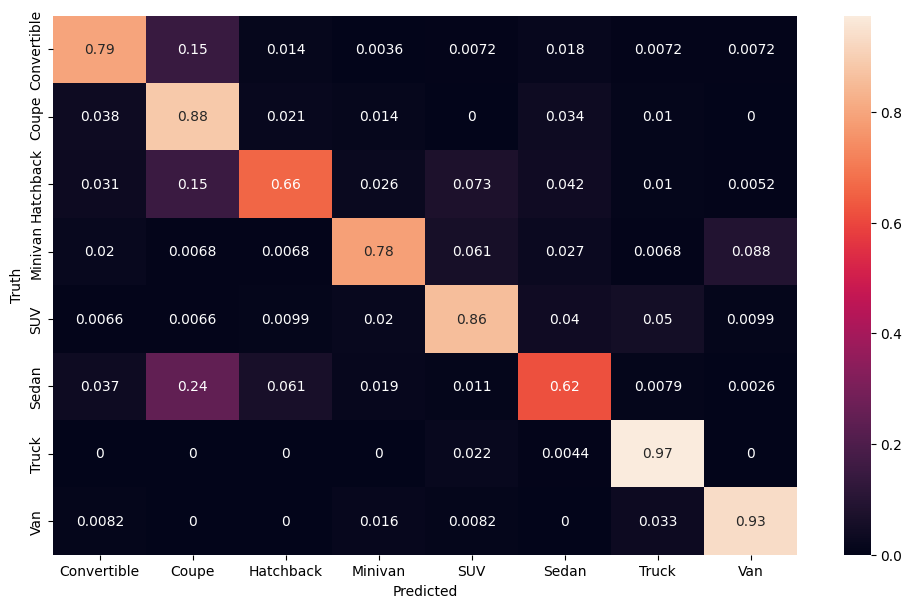

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('GreyScaleDataSet.png')

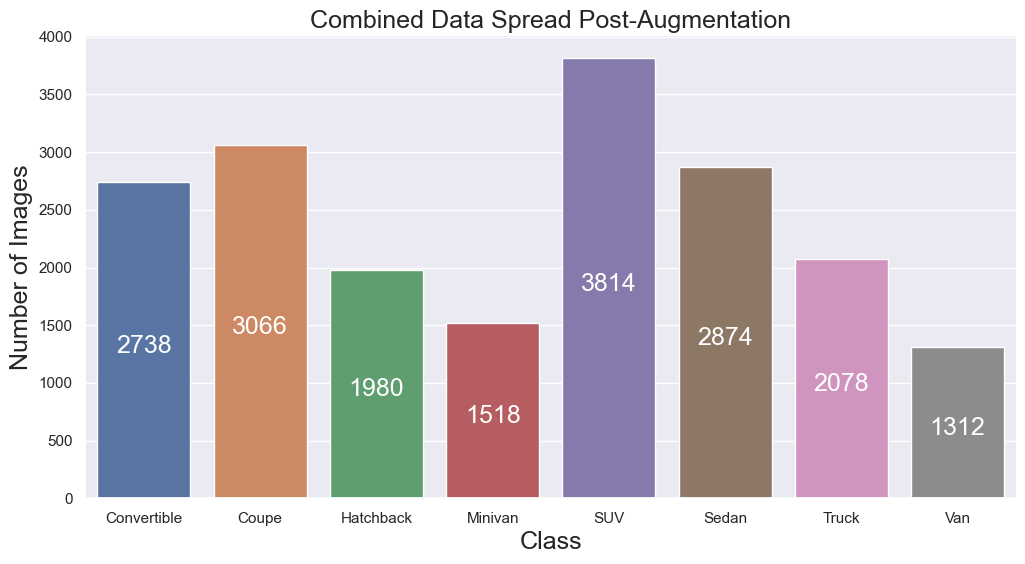

In [ ]:
class_keys = main_folder.classes
class_length_vals = []
for dir in os.listdir(main_dir):
    path = os.path.join((main_dir), dir)
    num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
    class_length_vals.append(num_files)

#data = {class_keys[i]: class_length_vals[i] for i in range(len(class_keys))}
data = pd.DataFrame(list(zip(class_keys, class_length_vals)), columns =['Class', 'Number of Images'])

fig, ax = plt.subplots(figsize=(12,6))

sn.set(style="darkgrid")
sn.barplot(data=data, x="Class", y="Number of Images")
plt.xlabel('Class', size=18)
plt.ylabel('Number of Images', size=18)
plt.title('Combined Data Spread Post-Augmentation', size=18)
plt.xticks(size=11)
plt.yticks(size=11)
for i, val in enumerate(class_length_vals):
    plt.text(x=i, y=(val-100)/2, s=str(val), 
                    color='white', fontsize=18, horizontalalignment='center', verticalalignment='center')

sn.despine();
sn.despine(left=True);
plt.savefig('bargraph.png')


In [ ]:
# import shutil
# for file in os.listdir("./stanford_cars_type_flipped+/Minivan"):
#     if "Van" in file:
#         shutil.move("./stanford_cars_type_flipped+/Minivan/"+file, "./stanford_cars_type_flipped+/Van")

In [ ]:
#using model on single image
from torchvision import transforms
#identifies a transformer to make all images the same size
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (int(120), int(180))),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(),
    #transforms.Grayscale()
])
img = "./SingleTestImages/Conv.jpg"

model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes= len(classes))
model.load_state_dict(torch.load("./car_model.pt"))
model.eval()
img_normalized = transformer(Image.open(img)).float()
img_normalized = img_normalized[np.newaxis, ...]
with torch.no_grad():
    
    output =model(img_normalized)
    # print(output)
    index = output.data.cpu().numpy().argmax()
    class_name = classes[index]
    print(class_name)


Convertible
